In [1]:
!nvidia-smi

Thu Oct 13 12:43:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import cv2
import numpy as np


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
categories = os.listdir('/content/drive/My Drive/data/Tomato_data/testing')

for c in categories:
  print(len(os.listdir('/content/drive/My Drive/data/Tomato_data/testing/'+c+'/')), len(os.listdir('/content/drive/My Drive/data/Tomato_data/training/'+c+'/')))

100 1000
100 1000
100 1000
100 1000
100 1000
100 1000
100 1000
100 1000
100 1000
100 1000


In [5]:
img_size = 100
def get_data(data_dir):
    data = [] 
    for label in categories: 
        path = os.path.join(data_dir, label)
        class_num = categories.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))#[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train = get_data('/content/drive/My Drive/data/Tomato_data/training')
val = get_data('/content/drive/My Drive/data/Tomato_data/testing')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [6]:
categories

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

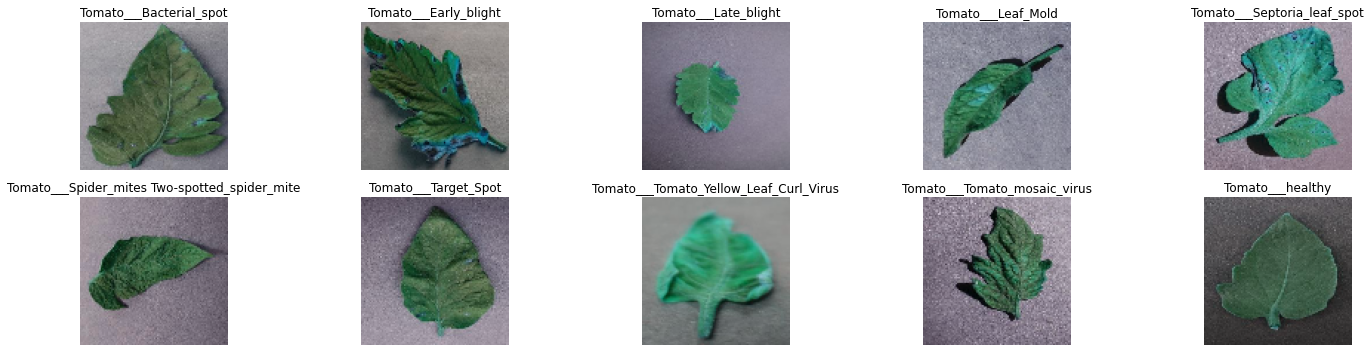

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols, figsize=(20,5) )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title])
        ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

total_images = 10
labels = categories
images = {labels[val[i*100][1]]: val[i*100][0] for i in range(total_images)}

display_multiple_img(images, 2, 5)

In [8]:
x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam

model = Sequential()
model.add(Conv2D(50,3,padding="same", activation="relu", input_shape=(100,100,3)))
model.add(MaxPool2D())

model.add(Conv2D(13, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(25, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(25, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(160,activation="relu"))
model.add(Dense(10, activation="softmax"))

model.summary()
#opt = Adam(lr=0.0001)
model.compile(optimizer = 'Adam' , loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , metrics = ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 50)      1400      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 13)        5863      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 13)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 25)        2950      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 25)       0

In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        #rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        #horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [11]:
history = model.fit(x_train,y_train,epochs = 100, validation_data = (x_val, y_val))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


313/313 [==============================] - 12s 15ms/step - loss: 1.5635 - accuracy: 0.4386 - val_loss: 0.9857 - val_accuracy: 0.6850
Epoch 2/100
313/313 [==============================] - 4s 14ms/step - loss: 0.7863 - accuracy: 0.7268 - val_loss: 0.7787 - val_accuracy: 0.7280
Epoch 3/100
313/313 [==============================] - 4s 13ms/step - loss: 0.5702 - accuracy: 0.8043 - val_loss: 0.5416 - val_accuracy: 0.8140
Epoch 4/100
313/313 [==============================] - 4s 14ms/step - loss: 0.4765 - accuracy: 0.8337 - val_loss: 0.5248 - val_accuracy: 0.8190
Epoch 5/100
313/313 [==============================] - 4s 14ms/step - loss: 0.3649 - accuracy: 0.8724 - val_loss: 0.4193 - val_accuracy: 0.8640
Epoch 6/100
313/313 [==============================] - 4s 14ms/step - loss: 0.3094 - accuracy: 0.8927 - val_loss: 0.4861 - val_accuracy: 0.8450
Epoch 7/100
313/313 [==============================] - 4s 14ms/step - loss: 0.2877 - accuracy: 0.8998 - val_loss: 0.4521 - val_accuracy: 0.8570
Epo

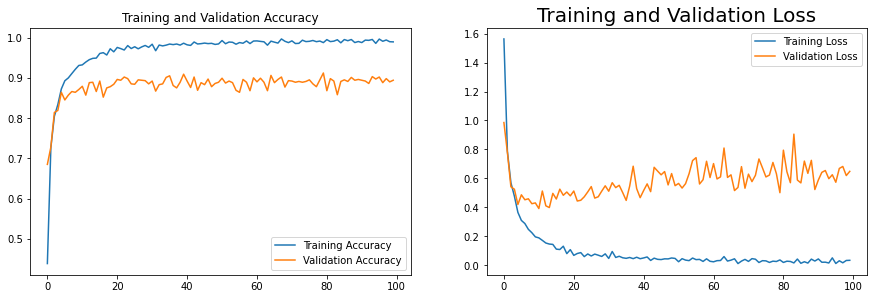

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss', fontdict={'size':20})
#plt.show()
plt.savefig('cnn_loss-acc.png',bbox_inches = 'tight')

In [13]:
predictions = np.argmax(model.predict(x_val), axis=1)
#predictions = predictions.reshape(1,-1)[0]
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_val, predictions, target_names = categories))

32/32 [==============================] - 0s 6ms/step
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.92      0.94      0.93       100
                        Tomato___Early_blight       0.88      0.80      0.84       100
                         Tomato___Late_blight       0.87      0.93      0.90       100
                           Tomato___Leaf_Mold       0.83      0.90      0.86       100
                  Tomato___Septoria_leaf_spot       0.84      0.83      0.83       100
Tomato___Spider_mites Two-spotted_spider_mite       0.94      0.88      0.91       100
                         Tomato___Target_Spot       0.88      0.79      0.83       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.90      1.00      0.95       100
                 Tomato___Tomato_mosaic_virus       0.92      0.99      0.95       100
                             Tomato___healthy       0.99      0.88      0.93

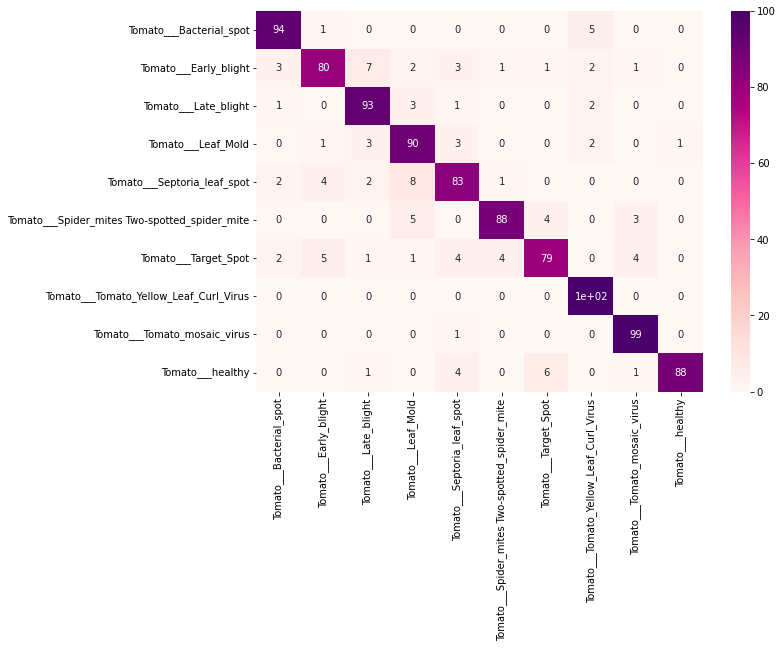

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm1 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm1, index = [i for i in categories],
              columns = [i for i in categories])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx1.png',bbox_inches = 'tight')

## Transfer Learning...

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (100, 100, 3), include_top = False, weights = "imagenet")

9406464/9406464 [==============================] - 0s 0us/step


In [16]:
base_model.trainable = False
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(20, activation="softmax")                                     
                                ])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 20)                25620     
                                                                 
Total params: 2,283,604
Trainable params: 25,620
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history1 = model.fit(x_train,y_train,epochs = 100 , validation_data = (x_val, y_val))

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


313/313 [==============================] - 9s 19ms/step - loss: 2.3328 - accuracy: 0.2689 - val_loss: 1.4622 - val_accuracy: 0.5100
Epoch 2/100
313/313 [==============================] - 5s 15ms/step - loss: 1.4213 - accuracy: 0.5192 - val_loss: 1.1187 - val_accuracy: 0.6250
Epoch 3/100
313/313 [==============================] - 5s 15ms/step - loss: 1.1568 - accuracy: 0.6050 - val_loss: 0.9840 - val_accuracy: 0.6830
Epoch 4/100
313/313 [==============================] - 5s 15ms/step - loss: 1.0173 - accuracy: 0.6508 - val_loss: 0.8953 - val_accuracy: 0.7070
Epoch 5/100
313/313 [==============================] - 5s 15ms/step - loss: 0.9170 - accuracy: 0.6880 - val_loss: 0.8406 - val_accuracy: 0.7100
Epoch 6/100
313/313 [==============================] - 5s 15ms/step - loss: 0.8494 - accuracy: 0.7085 - val_loss: 0.8041 - val_accuracy: 0.7290
Epoch 7/100
313/313 [==============================] - 5s 15ms/step - loss: 0.7953 - accuracy: 0.7300 - val_loss: 0.7700 - val_accuracy: 0.7360
Epoc

Text(0.5, 1.0, 'Training and Validation Loss')

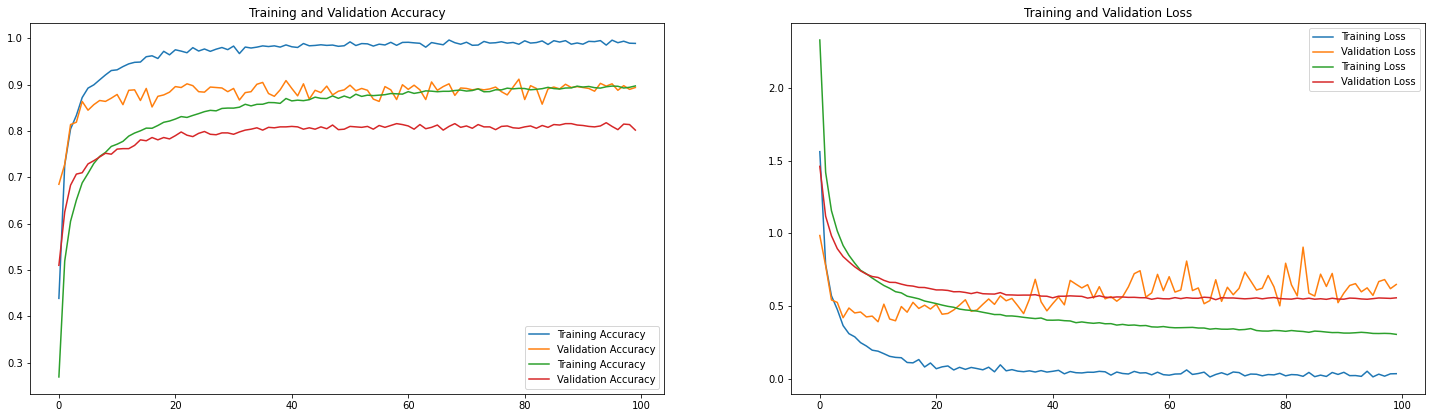

In [19]:

import matplotlib.pyplot as plt
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

epochs_range1 = range(100)
epochs_range2 = range(100)

plt.figure(figsize=(25, 15))
plt.subplot(2, 2, 1)

plt.plot(epochs_range1, acc, label='Training Accuracy')
plt.plot(epochs_range1, val_acc, label='Validation Accuracy')
plt.plot(epochs_range2, acc1, label='Training Accuracy')
plt.plot(epochs_range2, val_acc1, label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range1, loss, label='Training Loss')
plt.plot(epochs_range1, val_loss, label='Validation Loss')
plt.plot(epochs_range2, loss1, label='Training Loss')
plt.plot(epochs_range2, val_loss1, label='Validation Loss')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.savefig('tnrfr_cnn_loss-acc.png')

In [20]:
predictions = np.argmax(model.predict(x_val), axis=1)
#predictions = predictions.reshape(1,-1)[0]
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_val, predictions, target_names = categories))

32/32 [==============================] - 1s 14ms/step
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.87      0.89      0.88       100
                        Tomato___Early_blight       0.64      0.56      0.60       100
                         Tomato___Late_blight       0.65      0.84      0.73       100
                           Tomato___Leaf_Mold       0.77      0.79      0.78       100
                  Tomato___Septoria_leaf_spot       0.79      0.80      0.80       100
Tomato___Spider_mites Two-spotted_spider_mite       0.77      0.83      0.80       100
                         Tomato___Target_Spot       0.79      0.66      0.72       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.94      0.93      0.93       100
                 Tomato___Tomato_mosaic_virus       0.92      0.89      0.90       100
                             Tomato___healthy       0.93      0.83      0.8

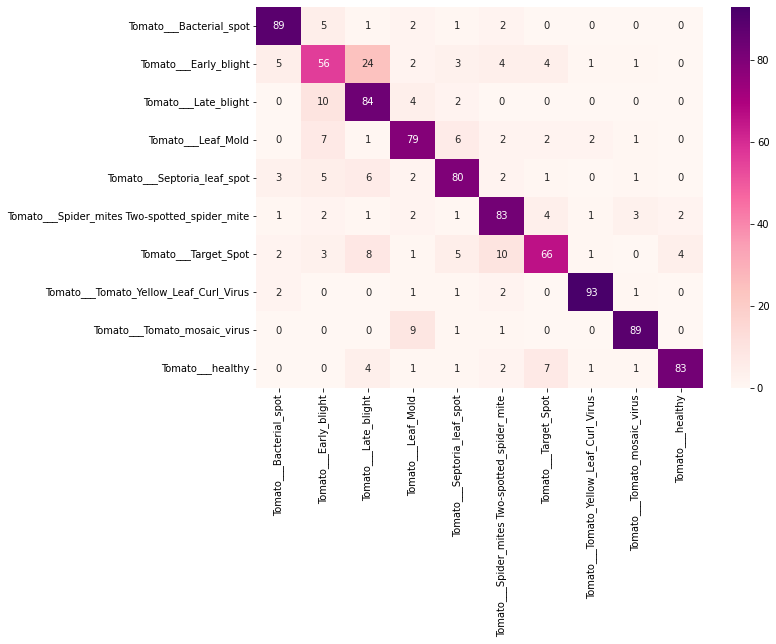

In [21]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm2 = confusion_matrix(y_val, predictions)
df_cm = pd.DataFrame(cm2, index = [i for i in categories],
              columns = [i for i in categories])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="RdPu")
plt.savefig('confusion_mrtx2.png',bbox_inches = 'tight')